In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod
 
xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [3]:
season = 'JFMAM'

### Filename for saved plots

In [4]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [5]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [6]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [7]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [8]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [9]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [10]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [11]:
ds_smr_sat = xr.open_dataset(sat_filename)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [12]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    BC_conc                                     (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [13]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [14]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

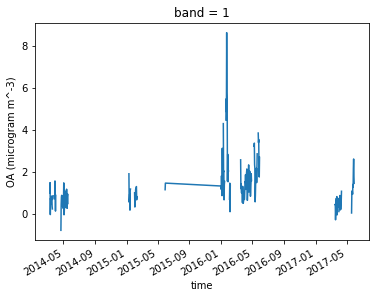

In [15]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [16]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.73925585, 1.42857748])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

In [17]:
ds_smr_sat_JA['OA (microgram m^-3)'].groupby(ds_smr_sat_JA['time.month']).count()

<xarray.DataArray 'OA (microgram m^-3)' (month: 5)>
array([33, 14, 45, 50, 53])
Coordinates:
    band     int64 1
  * month    (month) int64 1 2 3 4 5

## *MASK BY BC: 

In [137]:
ds_smr_sat_JA

<xarray.Dataset>
Dimensions:                                     (time: 1057, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 1
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 17.5...
    COT                                         (time, LAT, LON) float32 18.3...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 300....
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 287....
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 270....
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 2.10...
    ...                                          ...
    N50-500                                     (time) float64 nan nan ... nan
    N100-500                                    (time) float64 nan nan ... nan
    N200-500                                    (time) float64 nan nan ... nan
    BC_conc                                     (time) float64 nan nan ... nan
    day_of_year                                 (time) float64 nan nan ... nan
    hour                                        (time) float64 nan nan ... nan

In [18]:
ds_smr_sat_JA['OA (microgram m^-3)'].count()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(195)
Coordinates:
    band     int64 1

In [19]:
ds_smr_sat_JA = ds_smr_sat_JA.where(ds_smr_sat_JA['BC_conc'].fillna(0)<.05)

In [20]:
ds_smr_sat_JA['OA (microgram m^-3)'].count()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(95)
Coordinates:
    band     int64 1

In [21]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.54065085, 0.93865745])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

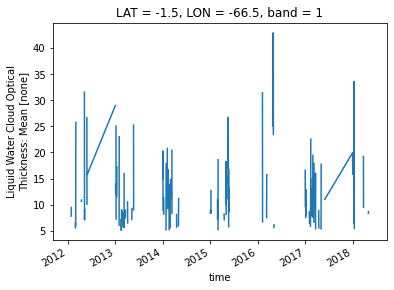

In [22]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [23]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [24]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [25]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 1057, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-01-01 ... 2018-05-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 216.0 192.0 169.0 ... nan nan
    CER (micrometer)     (time, LAT, LON) float32 17.54 16.1 16.06 ... nan nan
    COT                  (time, LAT, LON) float32 18.3 17.82 14.13 ... nan nan

In [26]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [27]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [28]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-12 -1.5 -66.5             -0.04000         289.0         22.750000   
           -2.5 -66.5             -0.04000         122.0         21.939999   
                -65.5             -0.04000         155.0         23.500000   
           -3.5 -53.5             -0.04000         124.0         23.959999   
                -52.5             -0.04000         175.0         21.449999   
...                                    ...           ...               ...   
2017-05-30 -7.5 -56.5              1.45007         219.0         19.920000   
                -55.5              1.45007         249.0         20.299999   
                -54.5              1.45007         305.0         21.049999   
                -53.5              1.45007         323.0         19.820000   
                -52.5              1.45007         338.0         22.389999   

                             COT  
time       LAT  LON               
2014-03-12 -1.5 -66.5  20.420000  
           -2.5 -66.5   9.610000  
                -65.5  10.050000  
           -3.5 -53.5   7.990000  
                -52.5  12.280000  
...                          ...  
2017-05-30 -7.5 -56.5  16.190001  
                -55.5  17.389999  
                -54.5  23.379999  
                -53.5  25.309999  
                -52.5  24.309999  

[3205 rows x 4 columns]

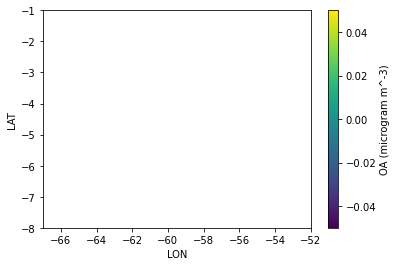

In [29]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [30]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [31]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


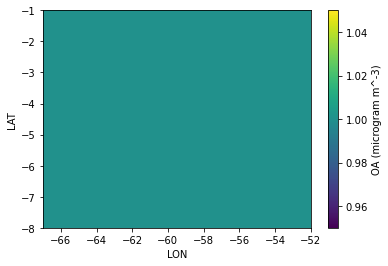

In [32]:
(~da_drop_pixels).plot()

In [33]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

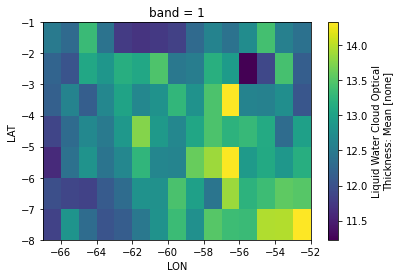

In [34]:
ds_smr_sat_JAs['COT'].mean('time').plot()

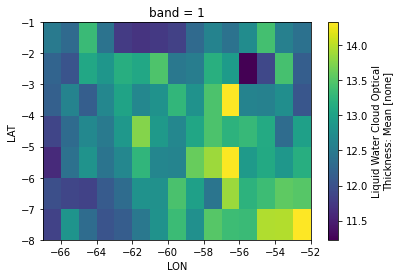

In [35]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 105.,  105.,  840., 2310., 2940., 1470.,  945.,  630.,  420.,
         210.]),
 array([-0.79      , -0.45369975, -0.1173995 ,  0.21890075,  0.555201  ,
         0.89150125,  1.2278015 ,  1.56410175,  1.900402  ,  2.23670225,
         2.5730025 ]),
 <BarContainer object of 10 artists>)

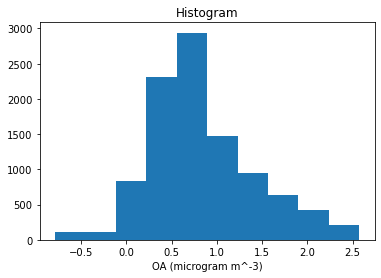

In [36]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [37]:
dic_OA_percentiles = dict()

In [38]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [39]:
df_hyy_1

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       lat  lon                                                          
2012-01-01 -7.5 -66.5                  NaN           NaN               NaN   
2012-01-02 -7.5 -66.5                  NaN           NaN               NaN   
2012-01-03 -7.5 -66.5                  NaN          73.0         18.779999   
2012-01-04 -7.5 -66.5                  NaN         114.0         18.580000   
2012-01-05 -7.5 -66.5                  NaN           NaN               NaN   
...                                    ...           ...               ...   
2018-05-27 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-28 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-29 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-30 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-31 -1.5 -52.5                  NaN         155.0         17.240000   

                             COT  
time       lat  lon               
2012-01-01 -7.5 -66.5        NaN  
2012-01-02 -7.5 -66.5        NaN  
2012-01-03 -7.5 -66.5   5.890000  
2012-01-04 -7.5 -66.5   8.630000  
2012-01-05 -7.5 -66.5        NaN  
...                          ...  
2018-05-27 -1.5 -52.5        NaN  
2018-05-28 -1.5 -52.5        NaN  
2018-05-29 -1.5 -52.5        NaN  
2018-05-30 -1.5 -52.5        NaN  
2018-05-31 -1.5 -52.5  13.719999  

[110985 rows x 4 columns]

df_smr_sat_JAsad model data:

## Load model data

In [40]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [41]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [42]:
l=-10
((l)%360)

350

In [43]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [44]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [45]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [46]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [47]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [48]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [49]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [50]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [51]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [52]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [53]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [54]:
cases_echam = [case_name_echam]

### EC-Earth

In [55]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [56]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [57]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [58]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [59]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [60]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [61]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month



In [62]:
df_mod_ec_earth.to_xarray()

<xarray.Dataset>
Dimensions:                   (time: 2558, lat: 10, lon: 22)
Coordinates:
  * time                      (time) datetime64[ns] 2011-12-31 ... 2018-12-31
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
Data variables: (12/107)
    station                   (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO'
    cc_all                    (time, lat, lon) float64 nan nan nan ... nan nan
    re_liq                    (time, lat, lon) float64 nan nan nan ... nan nan
    CWP                       (time, lat, lon) float64 nan nan nan ... nan nan
    tcwv                      (time, lat, lon) float64 nan nan nan ... nan nan
    tciw                      (time, lat, lon) float64 nan nan nan ... nan nan
    ...                        ...
    T                         (time, lat, lon) float64 nan nan ... 300.6 300.6
    M_DUCOS                   (time, lat, lon) float64 nan nan ... 5.649e-10
    M_DUCOI                   (time, lat, lon) float64 nan nan ... 2.493e-09
    N100_STP                  (time, lat, lon) float64 nan nan ... 367.3 367.3
    M_SOACOS                  (time, lat, lon) float64 nan nan ... 0.01402
    year                      (time, lat, lon) int64 2011 2011 ... 2018 2018

## Pick out months:

In [63]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

<AxesSubplot:ylabel='Frequency'>

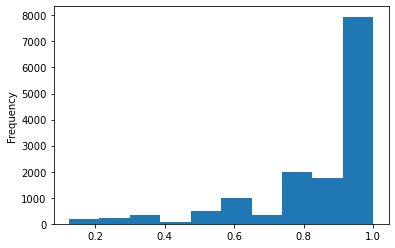

In [64]:
df_mod_echam['cl_time_ct'].plot.hist()

### Organize data in dictionary

In [65]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1



### *Scale CWP down for EC-Earth

In [66]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [67]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
    print('scaling CWP in EC-Earth')
dic_df[model_name_ec_earth]  = _df

scaling CWP in EC-Earth


<AxesSubplot:ylabel='Frequency'>

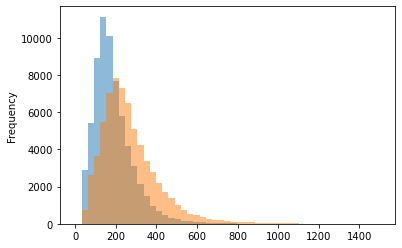

In [68]:
dic_df[model_name_ec_earth]['CWP'].plot.hist(alpha=.5, bins=np.linspace(0,1500))
dic_df[model_name_ec_earth]['CWP_orig'].plot.hist(alpha=.5, bins=np.linspace(0,1500))

## Check everythign is fine:

In [69]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 1059, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... nan nan
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... nan nan nan
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... nan nan nan
    ...              ...
    ORG_mass        (time, lat, lon) float64 9.209e-10 9.209e-10 ... 9.704e-10
    N200            (time, lat, lon) float64 8.246 4.128 9.056 ... 34.16 33.29
    T               (time,

## Rename variables:


<AxesSubplot:ylabel='Frequency'>

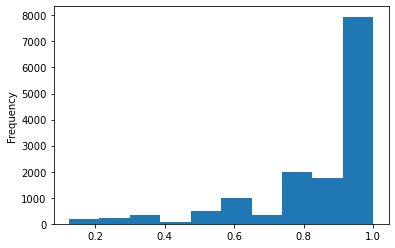

In [70]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [71]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    

}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [72]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [73]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [74]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

dropping OA in favor of OA_STP


In [75]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 1059, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... nan nan
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... nan nan nan
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... nan nan nan
    ...              ...
    ORG_mass        (time, lat, lon) float64 9.209e-10 9.209e-10 ... 9.704e-10
    N200            (time, lat, lon) float64 8.246 4.128 9.056 ... 34.16 33.29
    T         

<AxesSubplot:ylabel='Frequency'>

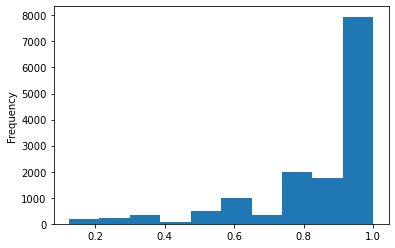

In [76]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

## Group by cloud water path 

#### Predefined bins

In [77]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




## Mask data

### moved to pre-processing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top

df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Bin model data:

CWP above 50. 

In [78]:
varl_categories = ['OA']#,'CLDFREE'

In [79]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [80]:
dic_df['EC-Earth']['N100-500_STP']

time        lat    lon   
2012-01-01  -7.37  293.20    274.027016
                   293.91    274.027016
                   294.61    274.027016
                   295.31    274.027016
                   296.02    274.027016
                                ...    
2018-05-31  -1.05  305.16    507.199523
                   305.86    507.199523
                   306.56    507.199523
                   307.27    507.199523
                   307.97    507.199523
Name: N100-500_STP, Length: 232980, dtype: float64

In [81]:
dic_df.keys()
ds_ec = dic_df['EC-Earth'].to_xarray()

In [82]:
a = dic_df['NorESM'].T.duplicated()

In [83]:
a.index

Index(['station', 'FSUS_DRF', 'FLNTCDRF', 'FREQL', 'FLNS', 'FSNSC', 'FLNT',
       'transmittance', 'TOT_CLD_VISTAU', 'ACTREL', 'TOT_CLD_VISTAU_s',
       'TGCLDLWP', 'FCTL', 'FCTI', 'CWP', 'FSUTADRF', 'COT', 'TGCLDCWP',
       'TOT_ICLD_VISTAU_s', 'FLNSC', 'FSDSCDRF', 'ACTNL', 'FSNT_DRF',
       'CLDFREE', 'FLNT_DRF', 'optical_depth', 'FLUS', 'FSDS_DRF', 'CLDTOT',
       'FLUTC', 'FSNT', 'r_eff', 'TGCLDCWP_incld', 'FSNS', 'TGCLDIWP', 'FREQI',
       'FSNTCDRF', 'TOT_ICLD_VISTAU', 'month', 'ismonth1', 'ismonth2',
       'ismonth3', 'ismonth4', 'ismonth5', 'ismonth6', 'ismonth7', 'ismonth8',
       'ismonth9', 'ismonth10', 'ismonth11', 'ismonth12', 'isJuly', 'isAug',
       'isJA', 'isSummer', 'ilev', 'lev', 'N100-500_STP', 'BC_AX', 'OM_NI',
       'N50_STP', 'BC_AI', 'DOD500', 'SOA_A1', 'BC_NI', 'BC_N', 'SO4_A2',
       'BC_A', 'N100_STP', 'N200_STP', 'SOA_LV', 'PS', 'OM_AC', 'SS_A1',
       'DOD440', 'SO4_NA', 'OM_AI', 'SS_A2', 'BC_AC', 'DST_A3', 'N150', 'OA',
       'SFmonoterp', 'T'

In [84]:
ds_no = dic_df['NorESM'].to_xarray()

In [85]:
dic_df[model_name_echam]

station     lcdnc_cm3  min_cl_tempair  ceff  \
time       lat       lon                                                   
2012-01-01 -2.797890 294.375    ATTO  4.430701e-35       213.28612   0.0   
                     296.250    ATTO  9.719341e-35       213.20883   0.0   
                     298.125    ATTO  6.922904e-35       212.94533   0.0   
                     300.000    ATTO -5.966645e-36       212.92976   0.0   
                     301.875    ATTO  3.178818e-35       213.12698   0.0   
...                              ...           ...             ...   ...   
2018-05-31 -6.528409 300.000    ATTO           NaN             NaN   NaN   
                     301.875    ATTO           NaN             NaN   NaN   
                     303.750    ATTO           NaN             NaN   NaN   
                     305.625    ATTO           NaN             NaN   NaN   
                     307.500    ATTO  9.468250e-35             NaN   0.0   

                              cl_time  lcdnc_ct_cm3    ceff_ct         CWP  \
time       lat       lon                                                     
2012-01-01 -2.797890 294.375      0.0      9.650340  16.343527  224.435970   
                     296.250      0.0      2.416409  14.716598  183.763240   
                     298.125      0.0      4.669168  16.791536   59.977024   
                     300.000      0.0     18.118134  12.863009   53.875362   
                     301.875      0.0     36.350810  16.347946  239.690460   
...                               ...           ...        ...         ...   
2018-05-31 -6.528409 300.000      NaN           NaN        NaN         NaN   
                     301.875      NaN           NaN        NaN         NaN   
                     303.750      NaN           NaN        NaN         NaN   
                     305.625      NaN           NaN        NaN         NaN   
                     307.500      0.0     44.569847  11.852790   84.103260   

                                    COT  cl_time_ct  ...  emi_monot_bio  \
time       lat       lon                             ...                  
2012-01-01 -2.797890 294.375  19.230902      1.0000  ...   1.513681e-10   
                     296.250  16.136960      0.8125  ...   1.969307e-10   
                     298.125   8.856040      1.0000  ...   3.431866e-10   
                     300.000   6.757799      1.0000  ...   2.544260e-10   
                     301.875  26.154974      0.6250  ...   0.000000e+00   
...                                 ...         ...  ...            ...   
2018-05-31 -6.528409 300.000        NaN         NaN  ...   1.789390e-10   
                     301.875        NaN         NaN  ...            NaN   
                     303.750        NaN         NaN  ...   1.966801e-10   
                     305.625        NaN         NaN  ...            NaN   
                     307.500  12.150103      1.0000  ...   1.924185e-10   

                                    N100   mmrtrN100  emi_isop_bio  \
time       lat       lon                                             
2012-01-01 -2.797890 294.375   99.768880  67215815.0  9.137577e-10   
                     296.250   58.768524  67215815.0  1.030914e-09   
                     298.125   36.833138  67215815.0  5.333989e-10   
                     300.000   92.452910  67215815.0  6.520385e-10   
                     301.875   93.162950  67215815.0  0.000000e+00   
...                                  ...         ...           ...   
2018-05-31 -6.528409 300.000   96.088820  60866877.0  1.769491e-09   
                     301.875         NaN  60866877.0           NaN   
                     303.750  215.774670  60866877.0  6.795642e-10   
                     305.625         NaN  60866877.0           NaN   
                     307.500  191.381770  60866877.0  7.864150e-10   

                                  ORG_mass       N200          T     mmrtrN50  \
time       lat       lon                                 

In [86]:
n_bins = 7

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name =='EC-Earth':
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.8401741861215409
1.9093700772103335
NorESM
4.694496238558584
7.607397580946982
EC-Earth


/tmp/ipykernel_87074/3884036908.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].notna().all(axis=1)]
/tmp/ipykernel_87074/3884036908.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_87074/3884036908.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_87074/3884036908.py:32: SettingWithCopyWarning: 
A val

2.9141690254590107
3.5807157094110185
Observations
0.594209284466839
1.0728023549917918


In [87]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_JFMAM.csv


33rd      66th   med_high   med_low      diff
ECHAM-SALSA   0.840174  1.909370   3.054291  0.482828  1.069196
NorESM        4.694496  7.607398  10.175519  3.568690  2.912901
EC-Earth      2.914169  3.580716   4.199538  2.520575  0.666547
Observations  0.594209  1.072802   1.525113  0.397500  0.478593

<AxesSubplot:ylabel='Frequency'>

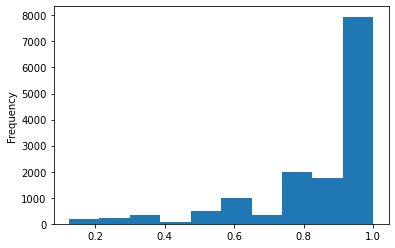

In [88]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [89]:
OA_percentile_df

33rd      66th   med_high   med_low      diff
ECHAM-SALSA   0.840174  1.909370   3.054291  0.482828  1.069196
NorESM        4.694496  7.607398  10.175519  3.568690  2.912901
EC-Earth      2.914169  3.580716   4.199538  2.520575  0.666547
Observations  0.594209  1.072802   1.525113  0.397500  0.478593

## Quantile cut

In [90]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [91]:
palette = 'Set2'

In [92]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [93]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
704
NorESM
625
EC-Earth
645
Observations
64


3205
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_JFMAM.png


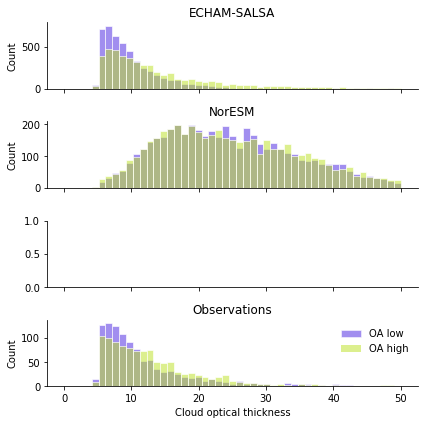

In [94]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key=='EC-Earth':
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3172
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFMAM.png


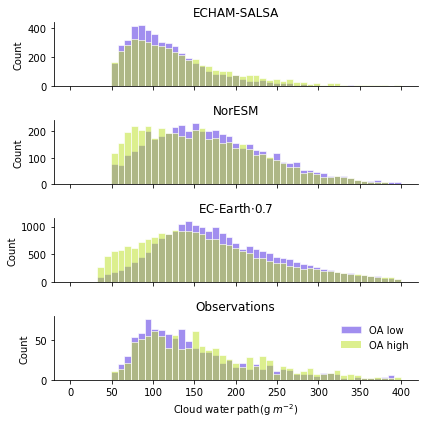

In [95]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1028
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFMAM.png


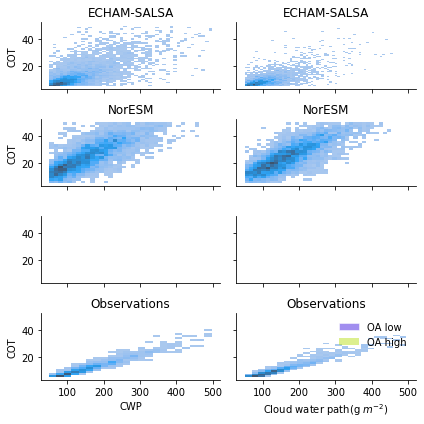

In [96]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1028
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFMAM.png


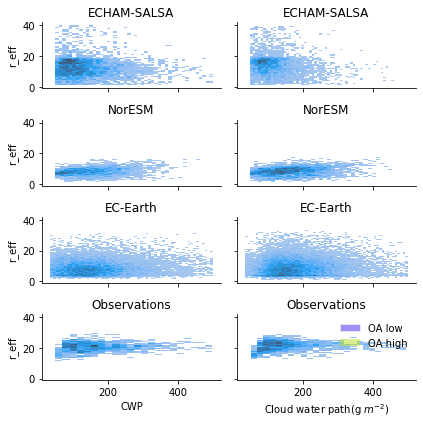

In [97]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [98]:
hue_v = 'OA high'

3172
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFMAM.png


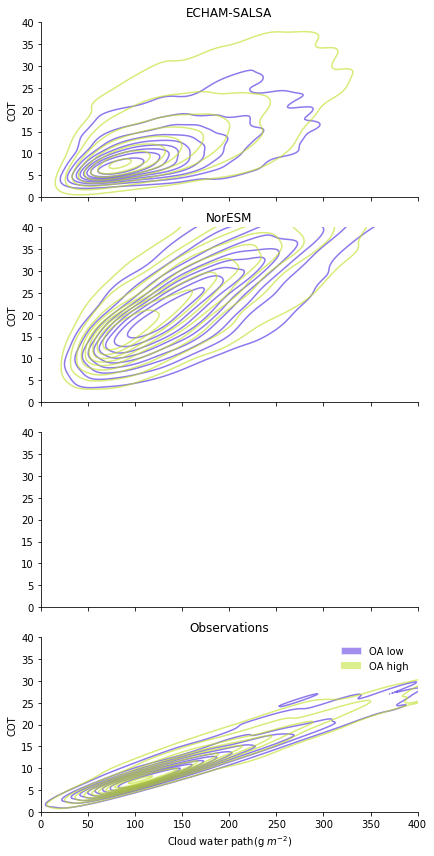

In [99]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

3205
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFMAM.png


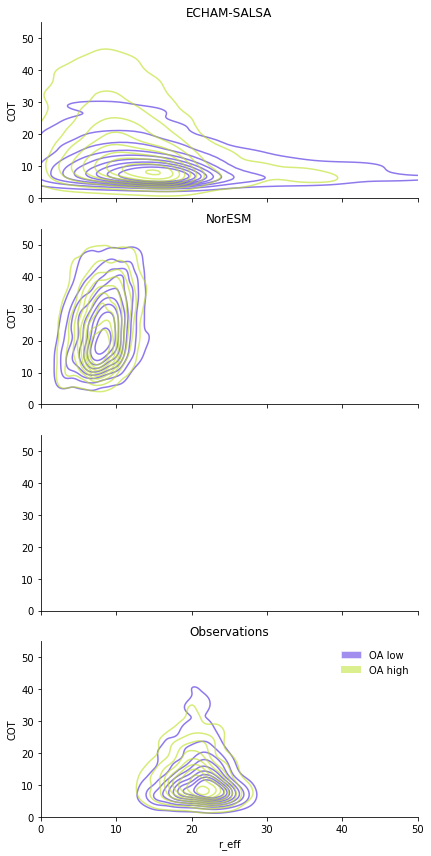

In [100]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

3172
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFMAM.png


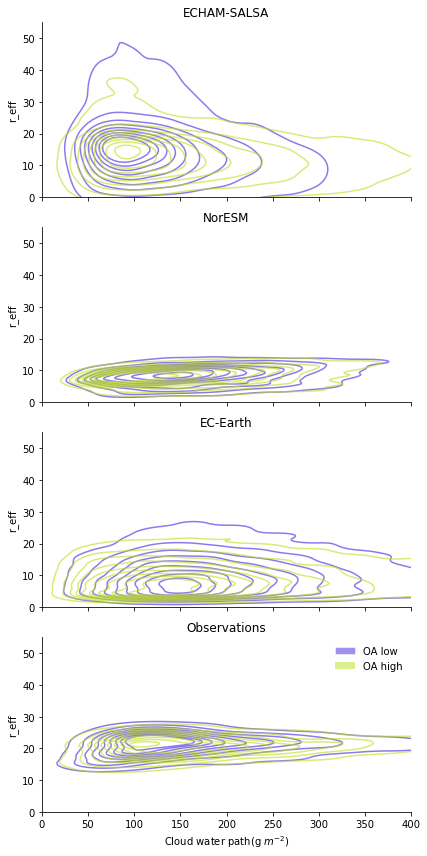

In [101]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

# fig.savefig(fn, dpi=150)
fig.tight_layout()
# fig.savefig(fn, dpi=150)
# fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

<AxesSubplot:ylabel='Frequency'>

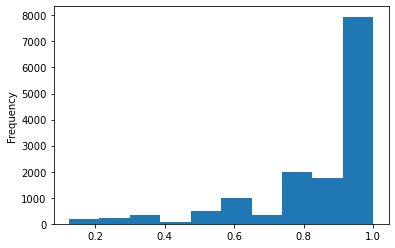

In [102]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [103]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

14298

In [104]:
len(dic_df['ECHAM-SALSA'])

14298

In [105]:
len(dic_df['NorESM'].dropna())

9265

14298
14246
66380
3205
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFMAM.png


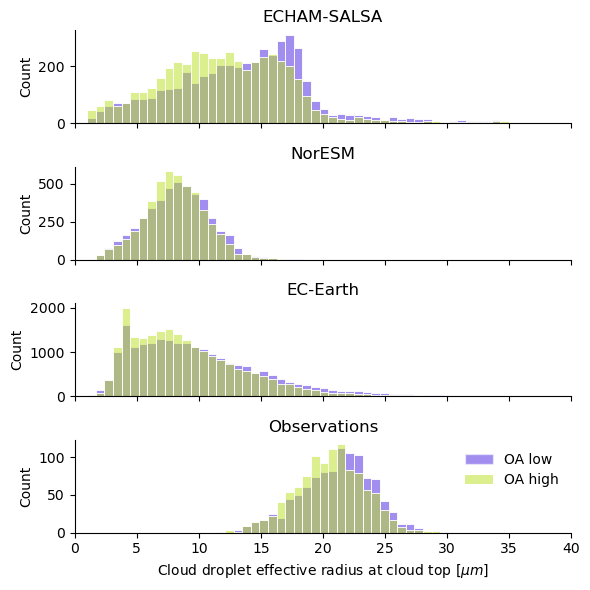

In [106]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [107]:
dic_df[model_name_echam]

station     lcdnc_cm3  min_cl_tempair  ceff  \
time       lat       lon                                                   
2012-01-01 -2.797890 294.375    ATTO  4.430701e-35       213.28612   0.0   
                     296.250    ATTO  9.719341e-35       213.20883   0.0   
                     298.125    ATTO  6.922904e-35       212.94533   0.0   
                     300.000    ATTO -5.966645e-36       212.92976   0.0   
                     301.875    ATTO  3.178818e-35       213.12698   0.0   
...                              ...           ...             ...   ...   
2018-05-31 -2.797890 298.125    ATTO  8.532191e-35             NaN   0.0   
                     301.875    ATTO  7.492583e-35       282.47668   0.0   
           -4.663150 298.125    ATTO  1.128593e-34       283.18707   0.0   
                     303.750    ATTO  7.613257e-35       274.96735   0.0   
           -6.528409 307.500    ATTO  9.468250e-35             NaN   0.0   

                              cl_time  lcdnc_ct_cm3    ceff_ct         CWP  \
time       lat       lon                                                     
2012-01-01 -2.797890 294.375      0.0      9.650340  16.343527  224.435970   
                     296.250      0.0      2.416409  14.716598  183.763240   
                     298.125      0.0      4.669168  16.791536   59.977024   
                     300.000      0.0     18.118134  12.863009   53.875362   
                     301.875      0.0     36.350810  16.347946  239.690460   
...                               ...           ...        ...         ...   
2018-05-31 -2.797890 298.125      0.0      1.877004  15.568005   64.214160   
                     301.875      0.0      2.755321  10.287270   77.383790   
           -4.663150 298.125      0.0      3.339521  15.960016   92.471730   
                     303.750      0.0    114.580880   7.773715   65.151375   
           -6.528409 307.500      0.0     44.569847  11.852790   84.103260   

                                    COT  cl_time_ct  ...  OA_category  \
time       lat       lon                             ...                
2012-01-01 -2.797890 294.375  19.230902      1.0000  ...         <NA>   
                     296.250  16.136960      0.8125  ...         <NA>   
                     298.125   8.856040      1.0000  ...         <NA>   
                     300.000   6.757799      1.0000  ...         <NA>   
                     301.875  26.154974      0.6250  ...         <NA>   
...                                 ...         ...  ...          ...   
2018-05-31 -2.797890 298.125   5.116022      1.0000  ...         <NA>   
                     301.875   5.620202      0.8125  ...         <NA>   
           -4.663150 298.125   6.794694      1.0000  ...         <NA>   
                     303.750  12.127717      1.0000  ...         <NA>   
           -6.528409 307.500  12.150103      1.0000  ...         <NA>   

                                 CWP_cut  CWP_cutl  CWP_cutlm  \
time       lat       lon                                        
2012-01-01 -2.797890 294.375  (200, 230]     215.0        215   
                     296.250  (170, 200]     185.0        184   
                     298.125    (50, 80]      65.0         68   
                     300.000    (50, 80]      65.0         68   
                     301.875  (230, 500]     365.0        269   
...                                  ...       ...        ...   
2018-05-31 -2.797890 298.125    (50, 80]      65.0         68   
                     301.875    (50, 80]      65.0         68   
           -4.663150 298.125   (80, 110]      95.0         94   
                     303.750    (50, 80]      65.0         68   
           -6.528409 307.500   (80, 110]      95.0         94   

                                                              CWP_cut2  \
time       lat       lon                                                 
2012-01-01 -2.797890 294.375                 (222.72734828571427, inf]   
       

df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

<AxesSubplot:ylabel='Frequency'>

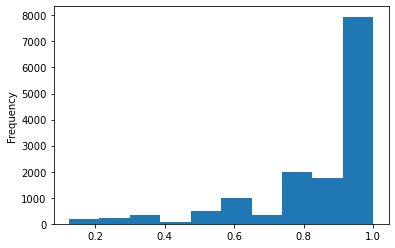

In [108]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [109]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [110]:
ds_nor = dic_df['NorESM'].to_xarray()

In [111]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 1057, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' 'ATTO' ... nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... nan nan
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... nan nan nan
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.79104971428572, 107.578309428...
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... 0.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 121.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object (74.874, 92.447] ... nan
    CWP_qcutl       (time, lat, lon) float64 83.66 62.44 124.1 ... nan nan nan

In [112]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 1057, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' 'ATTO' ... nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... nan nan
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... nan nan nan
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.79104971428572, 107.578309428...
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... 0.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 121.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object (74.874, 92.447] ... nan
    CWP_qcutl       (time, lat, lon) float64 83.66 62.44 124.1 ... nan nan nan

In [113]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 1057, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' 'ATTO' ... nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... nan nan
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... nan nan nan
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.79104971428572, 107.578309428...
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... 0.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 121.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object (74.874, 92.447] ... nan
    CWP_qcutl       (time, lat, lon) float64 83.66 62.44 124.1 ... nan nan nan

In [114]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(14246)

In [115]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 1057, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' 'ATTO' ... nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... nan nan
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... nan nan nan
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.79104971428572, 107.578309428...
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... 0.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 121.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object (74.874, 92.447] ... nan
    CWP_qcutl       (time, lat, lon) float64 83.66 62.44 124.1 ... nan nan nan

<AxesSubplot:ylabel='Frequency'>

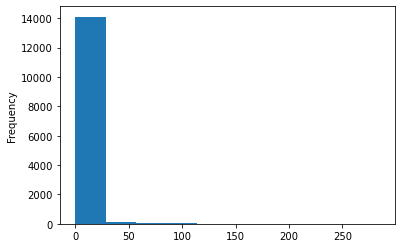

In [116]:
dic_df[model_name_echam]['lcdnc_cm3'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

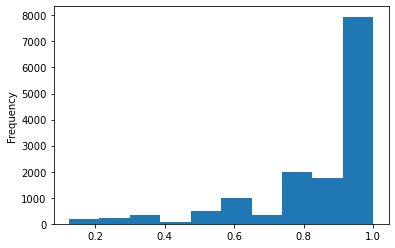

In [117]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

# Calculate difference between high OA and low


In [118]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [119]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [120]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [121]:
from sklearn.utils import resample

## Bootstrap resampling 

In [122]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [123]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
704
length of 67 is 1045 and 917
number of days is 317 and 332
1000
length of 93 is 1380 and 1088
number of days is 322 and 341
1000
length of 121 is 976 and 889
number of days is 308 and 327
1000
length of 149 is 596 and 607
number of days is 260 and 278
1000
length of 178 is 309 and 420
number of days is 185 and 221
1000
length of 206 is 191 and 278
number of days is 142 and 178
1000
length of 263 is 269 and 567
number of days is 159 and 236
1000
NorESM
Total number of days:
641
length of 71 is 475 and 811
number of days is 186 and 213
1000
length of 105 is 796 and 876
number of days is 253 and 246
1000
length of 140 is 950 and 838
number of days is 252 and 249
1000
length of 175 is 880 and 762
number of days is 257 and 227
1000
length of 210 is 630 and 600
number of days is 231 and 214
1000
length of 245 is 471 and 414
number of days is 198 and 179
1000
length of 300 is 518 and 429
number of days is 202 and 190
1000
EC-Earth
Observations
Total numbe

In [124]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
2.070706138396979
NorESM
1.2194750521693136
Observations
0.34604986281622024


In [125]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
Observations


# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JFMAM.png


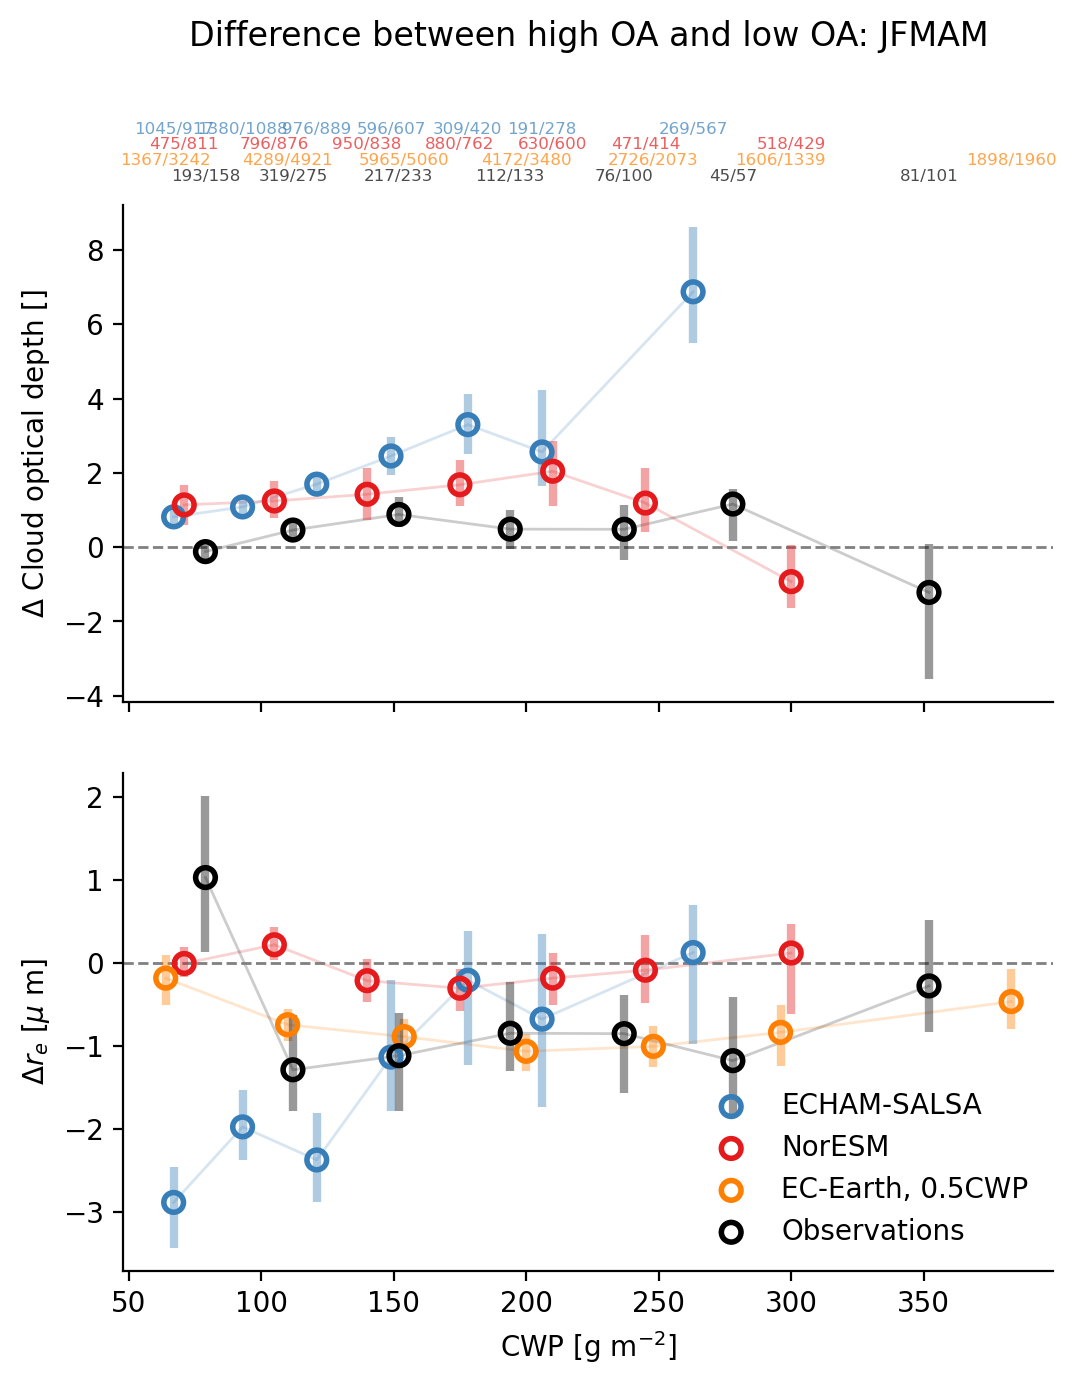

In [126]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JFMAM.png


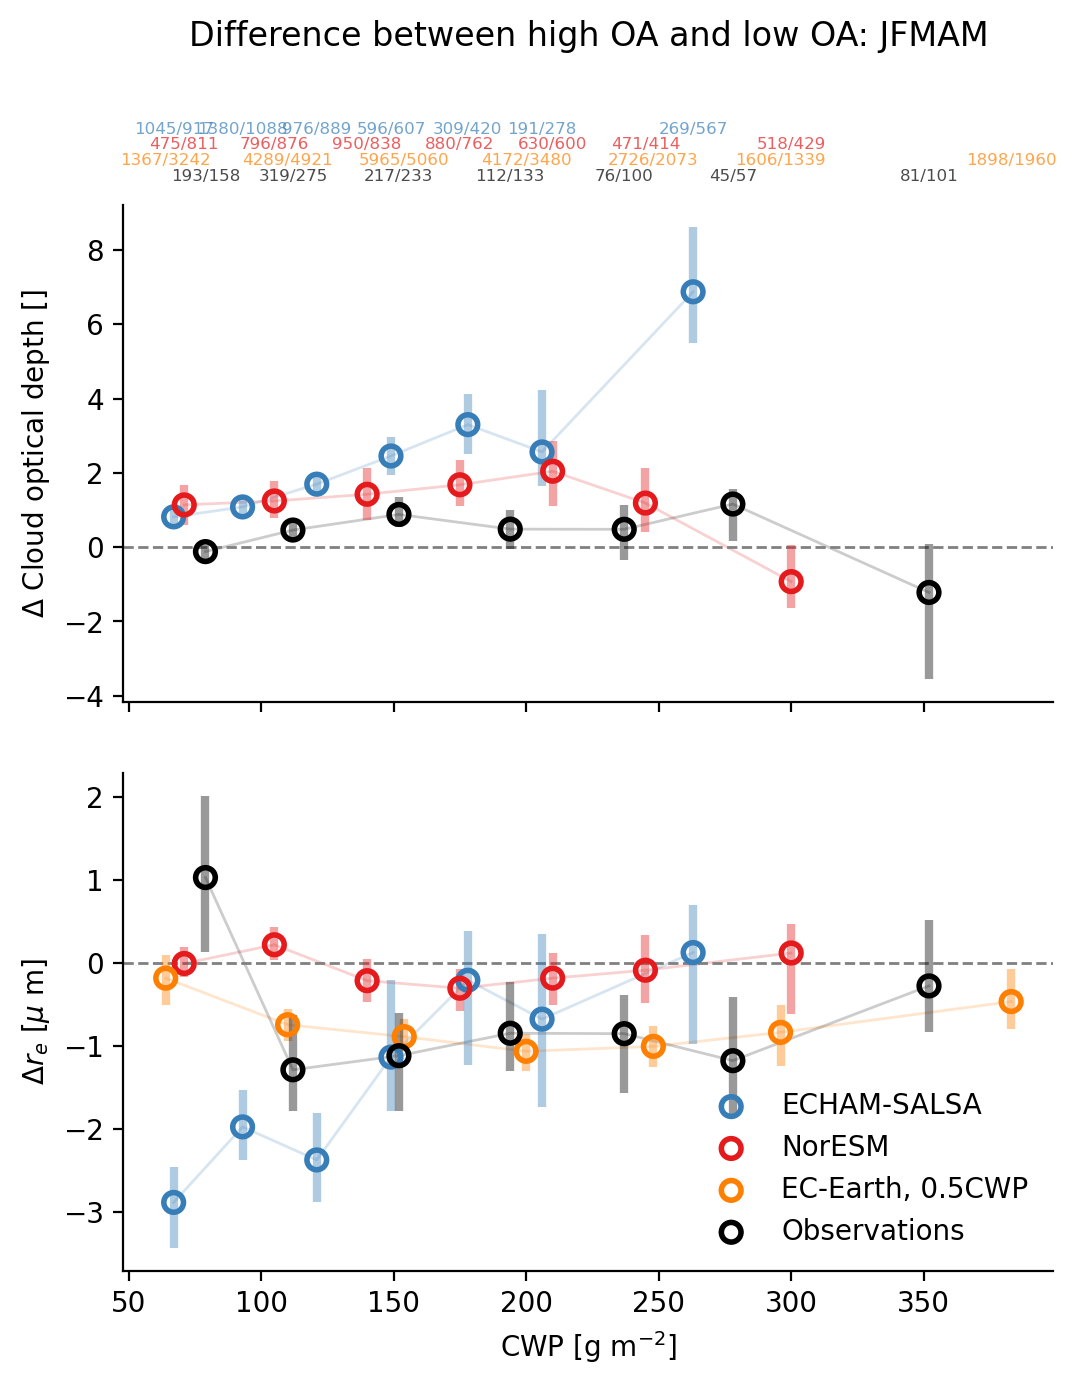

In [127]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [128]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [129]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFMAM.png


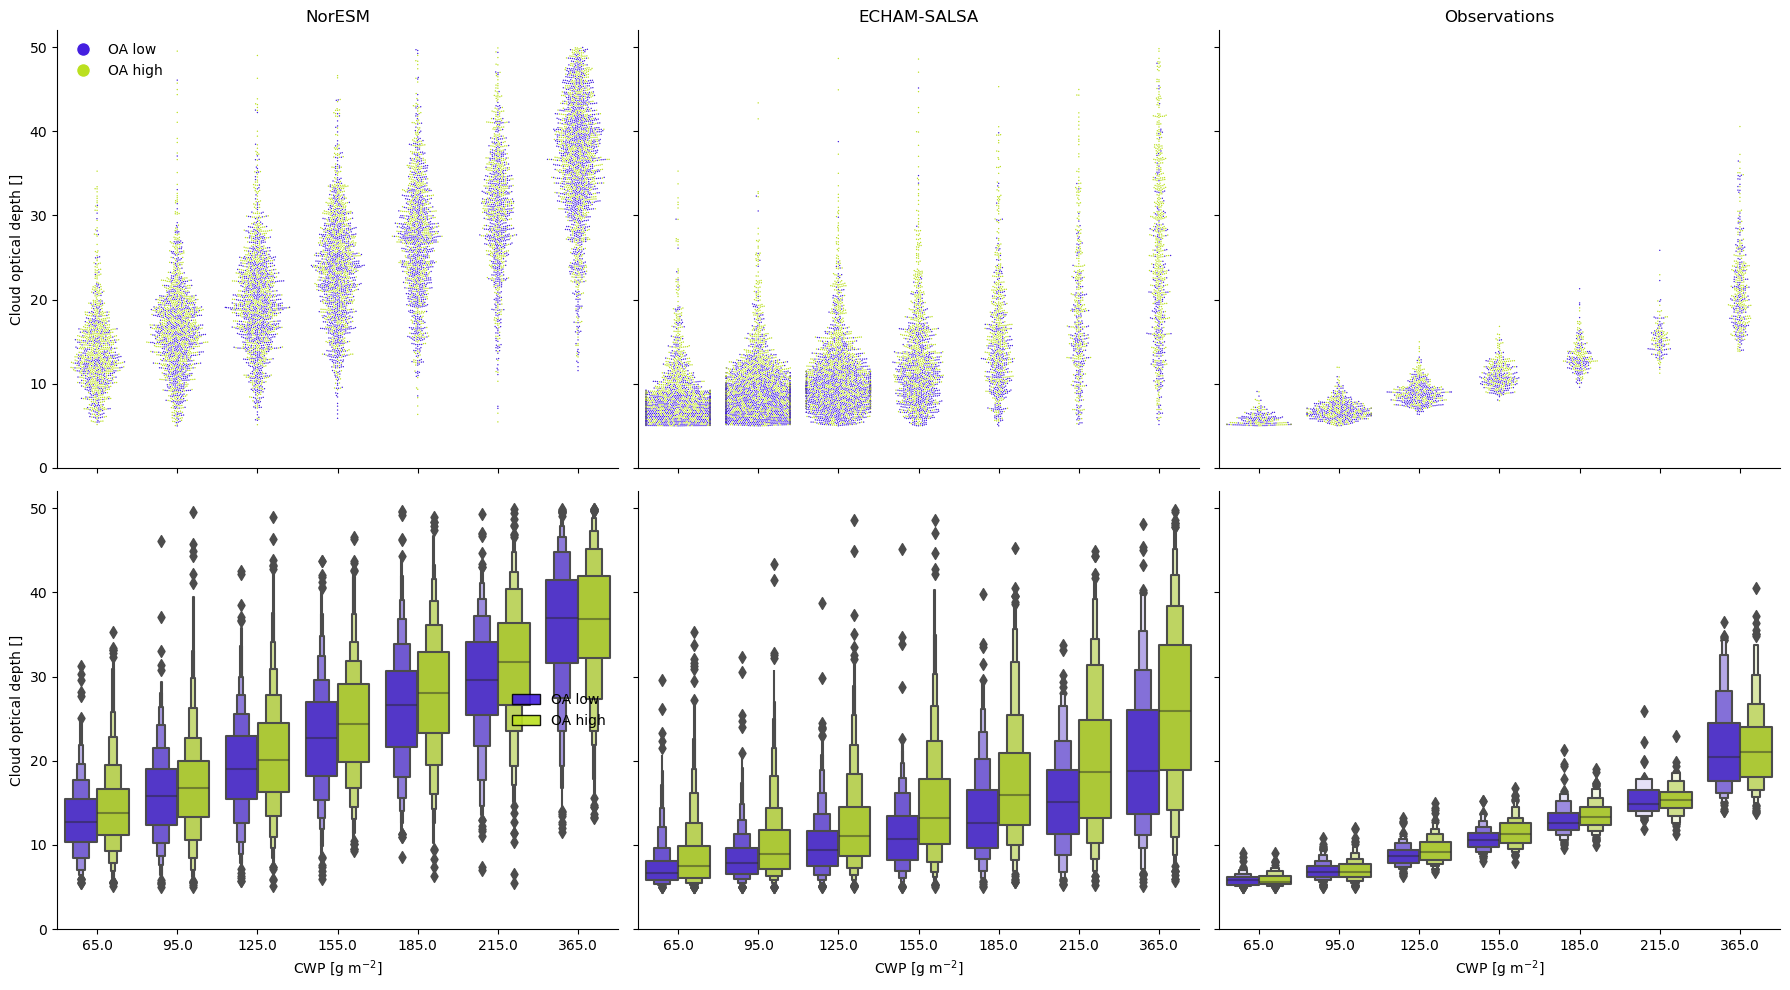

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFMAM.png


In [130]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFMAM.png


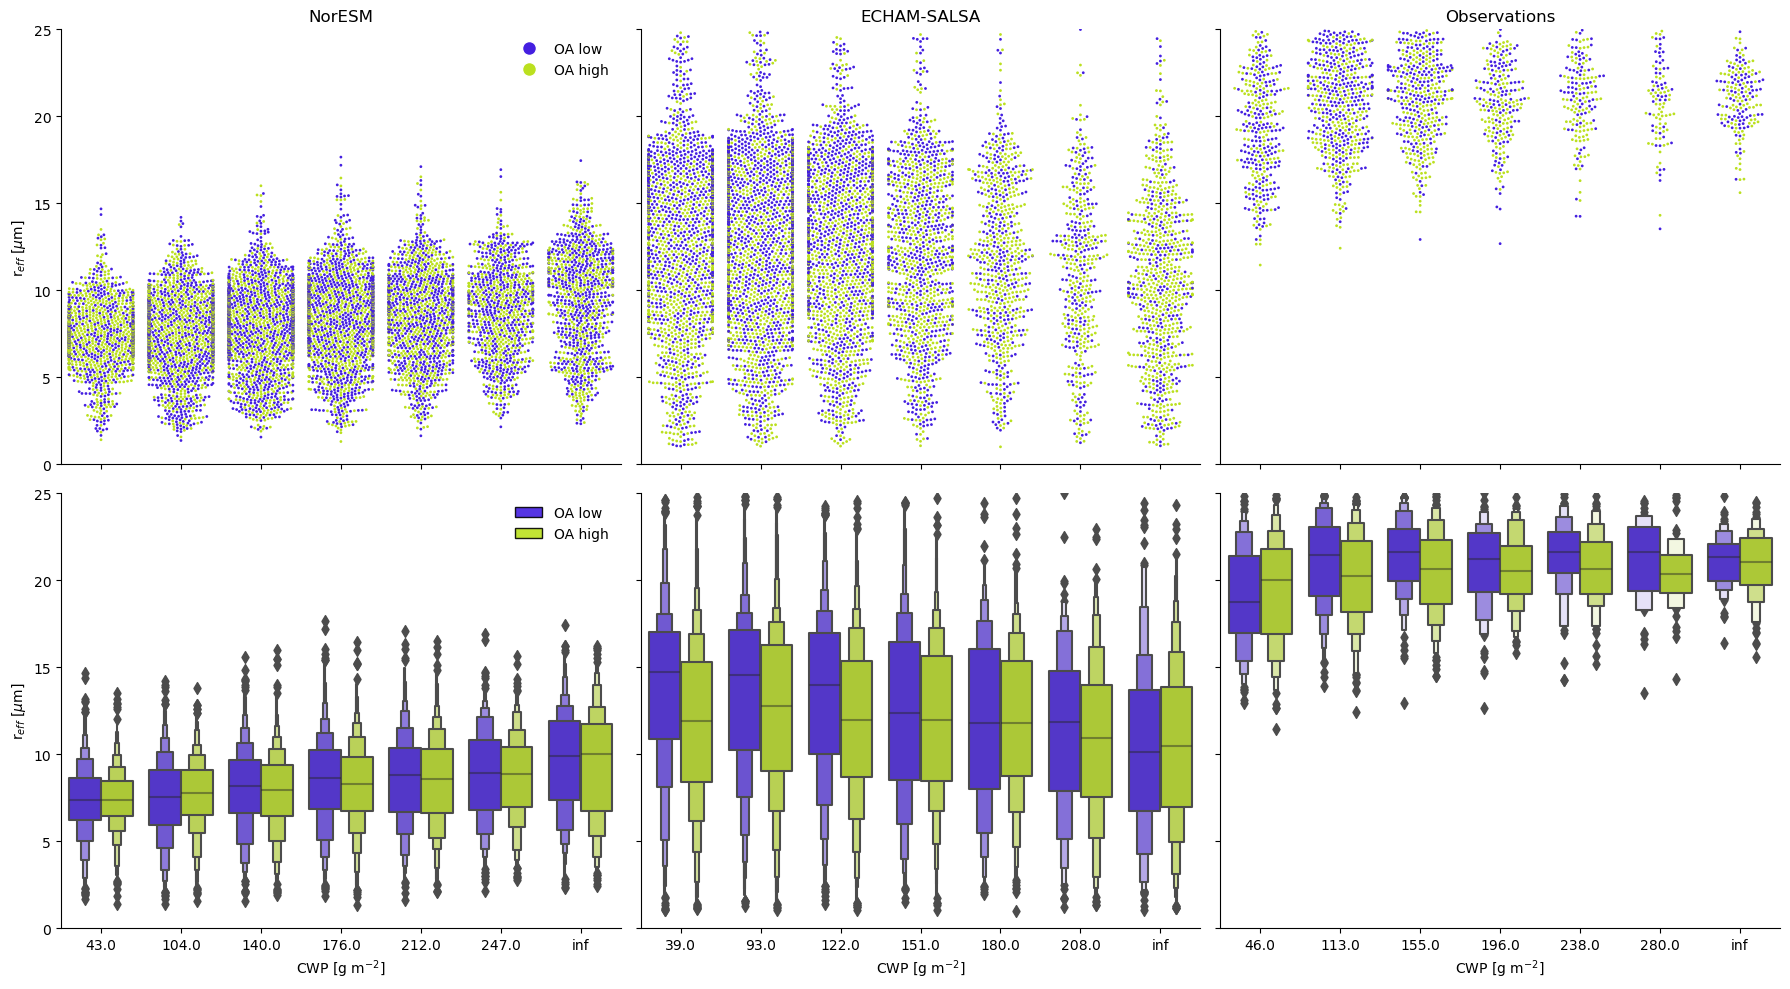

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFMAM.png


In [131]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFMAM.png


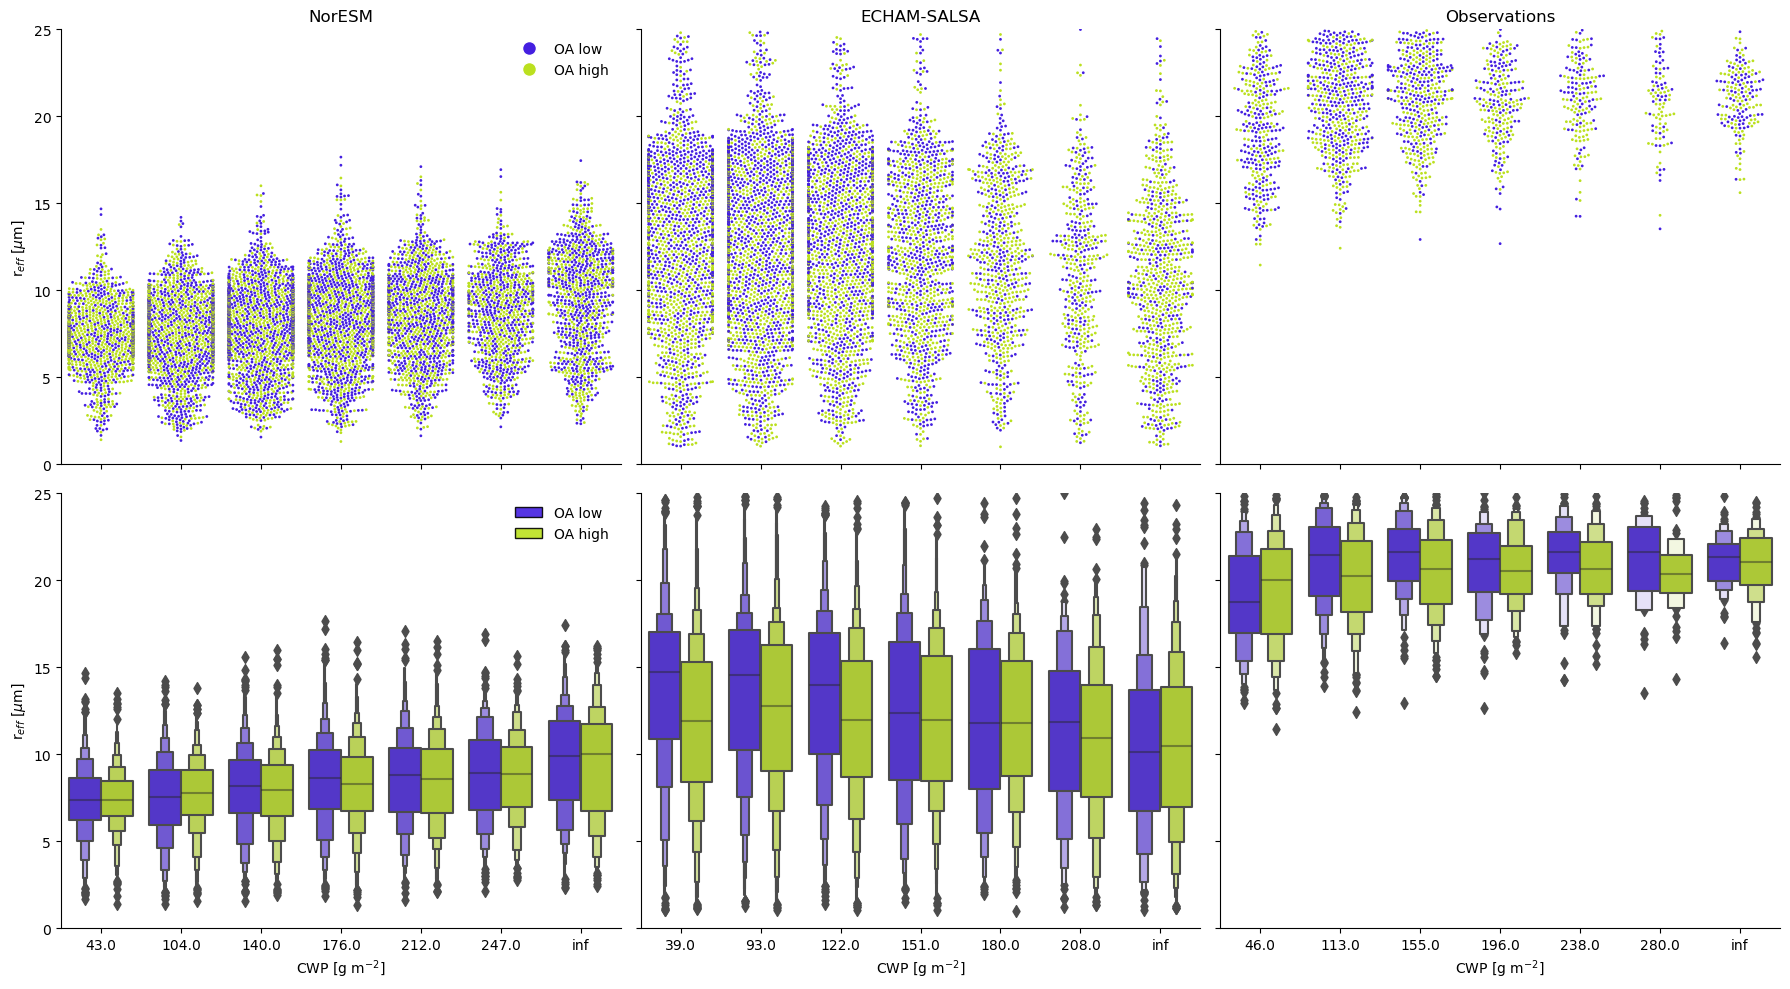

In [132]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 1108 and 968
number of days is 319 and 336
10000
length of 94 is 1410 and 1121
number of days is 323 and 343
10000
length of 124 is 982 and 883
number of days is 308 and 323
10000
length of 153 is 559 and 619
number of days is 262 and 279
10000
length of 184 is 297 and 402
number of days is 173 and 215
10000
length of 215 is 179 and 278
number of days is 136 and 179
10000
length of 269 is 224 and 490
number of days is 139 and 216
10000


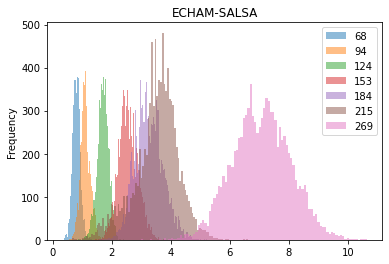

length of 68 is 363 and 648
number of days is 171 and 193
10000
length of 96 is 629 and 746
number of days is 227 and 228
10000
length of 125 is 768 and 719
number of days is 238 and 241
10000
length of 155 is 770 and 698
number of days is 252 and 236
10000
length of 184 is 696 and 592
number of days is 241 and 210
10000
length of 214 is 511 and 492
number of days is 212 and 203
10000
length of 267 is 983 and 835
number of days is 251 and 234
10000


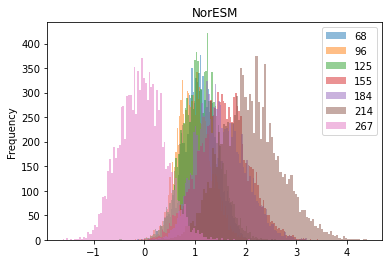

KeyError: 'COT'

In [133]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()